## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import logging

import pandas as pd

import optuna
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns

from storesales.baseline.sales_predictor import SalesPredictor
from storesales.baseline.utils import (
    run_study,
    load_baseline_data,
    load_submission,
    make_time_series_split,
)
from storesales.baseline.model_wrappers import (
    DailyMeanModelWrapper,
    ProphetWrapper,
    DayOfWeekMeanModelWrapper,
)
from storesales.baseline.param_suggestions import (
    IntSuggestions,
    FloatSuggestions,
    CategoricalSuggestions,
)
from storesales.baseline.constants import FAMILY_GROUPS, N_STORES
from storesales.constants import SUBMISSIONS_PATH

## Load && Prepare Data

In [3]:
train_df, test_df, holidays_df = load_baseline_data()

## Prepare SalesPredictor

In [4]:
initial = "760 days"  # train period

### DailyMeanModelWrapper

In [5]:
daily_mean_int_suggestions = [IntSuggestions("window", 3, 60)]

In [6]:
daily_wrapper = DailyMeanModelWrapper(int_suggestions=daily_mean_int_suggestions)

### DayOfWeekMeanModelWrapper

In [7]:
day_of_week_mean_int_suggestions = [
    IntSuggestions("weekdays_window", 3, 50),
    IntSuggestions("weekends_window", 1, 10),
]

In [8]:
day_of_week_wrapper = DayOfWeekMeanModelWrapper(
    int_suggestions=day_of_week_mean_int_suggestions
)

### ProphetWrapper

In [9]:
prophet_int_suggestions = [
    IntSuggestions("n_changepoints", 20, 50),
]
prophet_float_suggestions = [
    FloatSuggestions("changepoint_prior_scale", 0.01, 0.5),
    FloatSuggestions("holidays_prior_scale", 5, 80),
    FloatSuggestions("seasonality_prior_scale", 5, 80),
]
prophet_categorical_suggestions = [
    CategoricalSuggestions("seasonality_mode", ["additive", "multiplicative"]),
]

prophet_base_params = {
    "daily_seasonality": False,
    "weekly_seasonality": True,
    "yearly_seasonality": True,
    "uncertainty_samples": False,
    "holidays": holidays_df,
}

In [10]:
prophet_wrapper = ProphetWrapper(
    initial=initial,
    extra_regressors=["dcoilwtico"],
    int_suggestions=prophet_int_suggestions,
    float_suggestions=prophet_float_suggestions,
    categorical_suggestions=prophet_categorical_suggestions,
    model_base_params=prophet_base_params,
)

### SalesPredictor

In [61]:
model_wrappers = {
    DailyMeanModelWrapper.__name__: daily_wrapper,
    DayOfWeekMeanModelWrapper.__name__: day_of_week_wrapper,
    # ProphetWrapper.__name__: prophet_wrapper,
}

optuna_optimize_kwargs = dict(
    n_trials=100,
    show_progress_bar=True,
    timeout=45,
    n_jobs=1,
)

outer_cutoffs_dates = ["2017-02-27", "2017-05-15", "2017-07-31"]
outer_cutoffs = [pd.Timestamp(date) for date in outer_cutoffs_dates]
predictor = SalesPredictor(
    model_wrappers=model_wrappers,
    family_groups=FAMILY_GROUPS,
    outer_cutoffs=outer_cutoffs,
    inner_cutoffs=[-180, -49, -33, -17],
    outer_cv=TimeSeriesSplit(n_splits=3, test_size=16),
    optuna_optimize_kwargs=optuna_optimize_kwargs,
    n_group_store_family_choices=4,
    n_single_store_family_choices=2,
)

## Run Study

In [ ]:
dataset = make_time_series_split(train_df, predictor.outer_cutoffs, 16)

In [63]:
optuna.logging.set_verbosity(optuna.logging.WARN)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

sales_predictor = run_study(train_df, dataset, predictor)



Family: DELI - Store: 44


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=3, weekends=5) - RMSLE: 0.3117820617203064


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=27, weekends=3) - RMSLE: 0.2942086252327956


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=22, weekends=7) - RMSLE: 0.3068320577685059

Family: DELI - Store: 44 RMSLE: 0.304274248240536


Family: GROCERY I - Store: 21


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=3, weekends=4) - RMSLE: 0.3163730347992381


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=45, weekends=2) - RMSLE: 0.31246109027243324


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=3, weekends=8) - RMSLE: 0.33740705364722945

Family: GROCERY I - Store: 21 RMSLE: 0.32208039290630025


Family: GROCERY I - Store: 26


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=4, weekends=4) - RMSLE: 0.31028274707056397


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=12, weekends=1) - RMSLE: 0.33445096903026195


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=17, weekends=3) - RMSLE: 0.3179744463823663

Family: GROCERY I - Store: 26 RMSLE: 0.3209027208277308


Family: PERSONAL CARE - Store: 5


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=49, weekends=10) - RMSLE: 0.28007027458539824


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=40, weekends=10) - RMSLE: 0.3016588315903753


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=39, weekends=10) - RMSLE: 0.3144492606805086

Family: PERSONAL CARE - Store: 5 RMSLE: 0.2987261222854274


Family: POULTRY - Store: 19


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=50, weekends=3) - RMSLE: 0.32995866886903924


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=20, weekends=5) - RMSLE: 0.3020534666498351


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=16, weekends=9) - RMSLE: 0.3040238617981015

Family: POULTRY - Store: 19 RMSLE: 0.31201199910565863


Family: EGGS - Store: 4


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=44, weekends=2) - RMSLE: 0.33963349092464307


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=25, weekends=6) - RMSLE: 0.30564707457650936


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=14, weekends=2) - RMSLE: 0.30444615253220597

Family: EGGS - Store: 4 RMSLE: 0.31657557267778613


Family: BREAD/BAKERY - Store: 18


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=8) - RMSLE: 0.3449855385182049


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=20, weekends=2) - RMSLE: 0.3118056915997777


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=40, weekends=4) - RMSLE: 0.3015643057305829

Family: BREAD/BAKERY - Store: 18 RMSLE: 0.31945184528285514


Family: DAIRY - Store: 35


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=46, weekends=8) - RMSLE: 0.30292211808959013


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=37, weekends=6) - RMSLE: 0.3118800481577486


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=6, weekends=10) - RMSLE: 0.310850772450196

Family: DAIRY - Store: 35 RMSLE: 0.30855097956584493


Family: PET SUPPLIES - Store: 54


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=50, weekends=9) - RMSLE: 0.38030322896712226


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=3) - RMSLE: 0.4818849957693986


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=13, weekends=3) - RMSLE: 0.41950667567456873

Family: PET SUPPLIES - Store: 54 RMSLE: 0.4272316334703632


Family: CELEBRATION - Store: 15


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=3) - RMSLE: 0.4612998048708106


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=34, weekends=8) - RMSLE: 0.40259765894497285


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=5, weekends=10) - RMSLE: 0.4348434784852465

Family: CELEBRATION - Store: 15 RMSLE: 0.4329136474336767


Family: HOME CARE - Store: 46


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=45, weekends=1) - RMSLE: 0.46948130144374894


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=28, weekends=8) - RMSLE: 0.4012796534723423


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=9, weekends=10) - RMSLE: 0.4259365138348339

Family: HOME CARE - Store: 46 RMSLE: 0.43223248958364174


Family: PLAYERS AND ELECTRONICS - Store: 28


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=10, weekends=10) - RMSLE: 0.3798527758344294


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=28, weekends=10) - RMSLE: 0.40015479152751515


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=3, weekends=6) - RMSLE: 0.45029759455957025

Family: PLAYERS AND ELECTRONICS - Store: 28 RMSLE: 0.41010172064050493


Family: BABY CARE - Store: 12


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=54) - RMSLE: 0.25297598581050695


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=11, weekends=1) - RMSLE: 0.18702372431192116


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=12) - RMSLE: 0.19122604706403815

Family: BABY CARE - Store: 12 RMSLE: 0.21040858572882207


Family: BABY CARE - Store: 30


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=4) - RMSLE: 0.24356353790583546


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=5, weekends=10) - RMSLE: 0.19308088266846982


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=30, weekends=3) - RMSLE: 0.2096723901629821

Family: BABY CARE - Store: 30 RMSLE: 0.21543893691242913


Family: BOOKS - Store: 34


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=34) - RMSLE: 0.19367086533761635


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=56) - RMSLE: 0.15102091523297212


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=9, weekends=6) - RMSLE: 0.03753512576457812

Family: BOOKS - Store: 34 RMSLE: 0.12740896877838886


Family: BOOKS - Store: 37


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=14) - RMSLE: 0.18455424926950992


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=3) - RMSLE: 0.11149395421669304


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=7, weekends=2) - RMSLE: 0.028902968830556416

Family: BOOKS - Store: 37 RMSLE: 0.1083170574389198


Family: FROZEN FOODS - Store: 31


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=8) - RMSLE: 0.3886743822642109


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=24, weekends=8) - RMSLE: 0.3397142048589582


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=18, weekends=7) - RMSLE: 0.3191668862254215

Family: FROZEN FOODS - Store: 31 RMSLE: 0.3491851577828635


Family: FROZEN FOODS - Store: 40


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=8) - RMSLE: 0.3886743822642109


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=45, weekends=4) - RMSLE: 0.34477869416243556


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=10, weekends=7) - RMSLE: 0.32188129536391186

Family: FROZEN FOODS - Store: 40 RMSLE: 0.3517781239301861


Family: GROCERY II - Store: 12


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=4, weekends=10) - RMSLE: 0.5959394691421553


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=3) - RMSLE: 0.8236731416576426


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=4) - RMSLE: 0.708353473470289

Family: GROCERY II - Store: 12 RMSLE: 0.7093220280900289


Family: GROCERY II - Store: 5


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=8) - RMSLE: 0.5695167401236549


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=50, weekends=2) - RMSLE: 0.5891269954316404


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=4) - RMSLE: 0.708353473470289

Family: GROCERY II - Store: 5 RMSLE: 0.6223324030085281


Family: HARDWARE - Store: 53


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=17, weekends=7) - RMSLE: 0.5412341929059056


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=44, weekends=10) - RMSLE: 0.5427338274655231


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=25) - RMSLE: 0.5435144494038469

Family: HARDWARE - Store: 53 RMSLE: 0.5424941565917585


Family: HARDWARE - Store: 24


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=16) - RMSLE: 0.5478414470464292


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=15) - RMSLE: 0.5577083919683007


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=29) - RMSLE: 0.5465793154344358

Family: HARDWARE - Store: 24 RMSLE: 0.5507097181497219


Family: HOME AND KITCHEN I - Store: 42


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=5, weekends=4) - RMSLE: 0.6297548180505301


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=47, weekends=2) - RMSLE: 0.5297759730885608


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=10, weekends=2) - RMSLE: 0.49578016085731846

Family: HOME AND KITCHEN I - Store: 42 RMSLE: 0.5517703173321364


Family: HOME AND KITCHEN I - Store: 7


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=7) - RMSLE: 0.6855604540148155


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=13) - RMSLE: 0.5551288188405321


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=60) - RMSLE: 0.49939747659532957

Family: HOME AND KITCHEN I - Store: 7 RMSLE: 0.580028916483559


Family: HOME AND KITCHEN II - Store: 8


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=11, weekends=6) - RMSLE: 0.41517102143958656


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=9, weekends=10) - RMSLE: 0.43179981059229305


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=9, weekends=2) - RMSLE: 0.49784976765667227

Family: HOME AND KITCHEN II - Store: 8 RMSLE: 0.4482735332295173


Family: HOME AND KITCHEN II - Store: 28


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=40, weekends=4) - RMSLE: 0.41707414592779535


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=36, weekends=8) - RMSLE: 0.4407188468276814


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=39, weekends=9) - RMSLE: 0.4580934450167311

Family: HOME AND KITCHEN II - Store: 28 RMSLE: 0.438628812590736


Family: HOME APPLIANCES - Store: 54


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=60) - RMSLE: 0.4007066967719059


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=24) - RMSLE: 0.4354416990924544


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=3, weekends=6) - RMSLE: 0.3172725755017297

Family: HOME APPLIANCES - Store: 54 RMSLE: 0.38447365712202997


Family: HOME APPLIANCES - Store: 29


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=3) - RMSLE: 0.45757819379254244


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=6) - RMSLE: 0.45443534660133617


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=50, weekends=2) - RMSLE: 0.37242711621991487

Family: HOME APPLIANCES - Store: 29 RMSLE: 0.4281468855379312


Family: LAWN AND GARDEN - Store: 17


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=43) - RMSLE: 0.47875740797370564


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=22) - RMSLE: 0.6654199876563287


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=37, weekends=6) - RMSLE: 0.38101400397027474

Family: LAWN AND GARDEN - Store: 17 RMSLE: 0.508397133200103


Family: LAWN AND GARDEN - Store: 49


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=6, weekends=6) - RMSLE: 0.4196485129282773


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=3, weekends=7) - RMSLE: 0.7038027676209379


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=49, weekends=1) - RMSLE: 0.39001130723161304

Family: LAWN AND GARDEN - Store: 49 RMSLE: 0.5044875292602761


Family: LINGERIE - Store: 43


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=50, weekends=10) - RMSLE: 0.6023362898693304


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=29) - RMSLE: 0.7752001216721782


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=3) - RMSLE: 0.693018166250058

Family: LINGERIE - Store: 43 RMSLE: 0.6901848592638555


Family: LINGERIE - Store: 29


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=3, weekends=10) - RMSLE: 0.6553257296678727


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=3, weekends=10) - RMSLE: 0.7342737532716113


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=21, weekends=3) - RMSLE: 0.6514776651818828

Family: LINGERIE - Store: 29 RMSLE: 0.6803590493737889


Family: LIQUOR,WINE,BEER - Store: 36


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=4, weekends=7) - RMSLE: 0.71881381900067


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=6, weekends=8) - RMSLE: 0.7172764644698068


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=10, weekends=9) - RMSLE: 0.6143403508053531

Family: LIQUOR,WINE,BEER - Store: 36 RMSLE: 0.6834768780919432


Family: LIQUOR,WINE,BEER - Store: 46


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=8) - RMSLE: 0.7721374228395335


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=46, weekends=2) - RMSLE: 0.7620985252150737


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=22, weekends=9) - RMSLE: 0.6097263677118951

Family: LIQUOR,WINE,BEER - Store: 46 RMSLE: 0.7146541052555007


Family: MAGAZINES - Store: 14


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=5, weekends=4) - RMSLE: 0.5830547413795465


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=15, weekends=5) - RMSLE: 0.5123915981327107


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=48, weekends=10) - RMSLE: 0.5124343125493857

Family: MAGAZINES - Store: 14 RMSLE: 0.535960217353881


Family: MAGAZINES - Store: 15


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=30) - RMSLE: 0.5607643378482212


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=43, weekends=3) - RMSLE: 0.5047457193527205


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=14, weekends=10) - RMSLE: 0.5184196931892283

Family: MAGAZINES - Store: 15 RMSLE: 0.5279765834633899


Family: MEATS - Store: 51


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=9) - RMSLE: 0.3074362113839999


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=25, weekends=2) - RMSLE: 0.2770748261123669


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=50, weekends=7) - RMSLE: 0.28759412685551555

Family: MEATS - Store: 51 RMSLE: 0.29070172145062745


Family: MEATS - Store: 20


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=45, weekends=10) - RMSLE: 0.3084556302042978


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=26, weekends=7) - RMSLE: 0.2703474946155023


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=45, weekends=8) - RMSLE: 0.287931997212958

Family: MEATS - Store: 20 RMSLE: 0.28891170734425264


Family: SCHOOL AND OFFICE SUPPLIES - Store: 32


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=53) - RMSLE: 0.398429373571041


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=5) - RMSLE: 0.7472289956138334


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=9) - RMSLE: 1.0103767740237137

Family: SCHOOL AND OFFICE SUPPLIES - Store: 32 RMSLE: 0.7186783810695294


Family: SCHOOL AND OFFICE SUPPLIES - Store: 41


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=8) - RMSLE: 0.3738333696791925


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=3) - RMSLE: 0.7126704384073037


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DailyMeanModel(window=4) - RMSLE: 0.9377161509796933

Family: SCHOOL AND OFFICE SUPPLIES - Store: 41 RMSLE: 0.6747399863553966


Family: SEAFOOD - Store: 21


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=49, weekends=1) - RMSLE: 0.6028766465401014


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=49, weekends=2) - RMSLE: 0.5341668147131465


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=15, weekends=9) - RMSLE: 0.5063760264547287

Family: SEAFOOD - Store: 21 RMSLE: 0.5478064959026588


Family: SEAFOOD - Store: 42


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=43, weekends=2) - RMSLE: 0.563583401382202


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=50, weekends=10) - RMSLE: 0.5201165645643122


  0%|          | 0/100 [00:00<?, ?it/s]

Outer: DOWMeanModel(weekdays=27, weekends=10) - RMSLE: 0.5054416151132843

Family: SEAFOOD - Store: 42 RMSLE: 0.5297138603532662


Total RMSLE: 0.41105948306828793


## Analyze Loss Results

In [70]:
def make_plot(data_dict, loss_sample_name, title):
    plot_data = []
    for i_group, samples in enumerate(data_dict.values()):
        for sample, losses in samples[loss_sample_name].items():
            for loss in losses:
                plot_data.append([i_group, sample, loss])
    
    df = pd.DataFrame(plot_data, columns=["Group", loss_sample_name, "Loss"])
    
    plt.figure(figsize=(16, 8))
    sns.boxplot(x="Group", y="Loss", hue=loss_sample_name, data=df)
    
    plt.yscale("log")
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
    plt.gca().ticklabel_format(style="plain", axis="y")
    
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

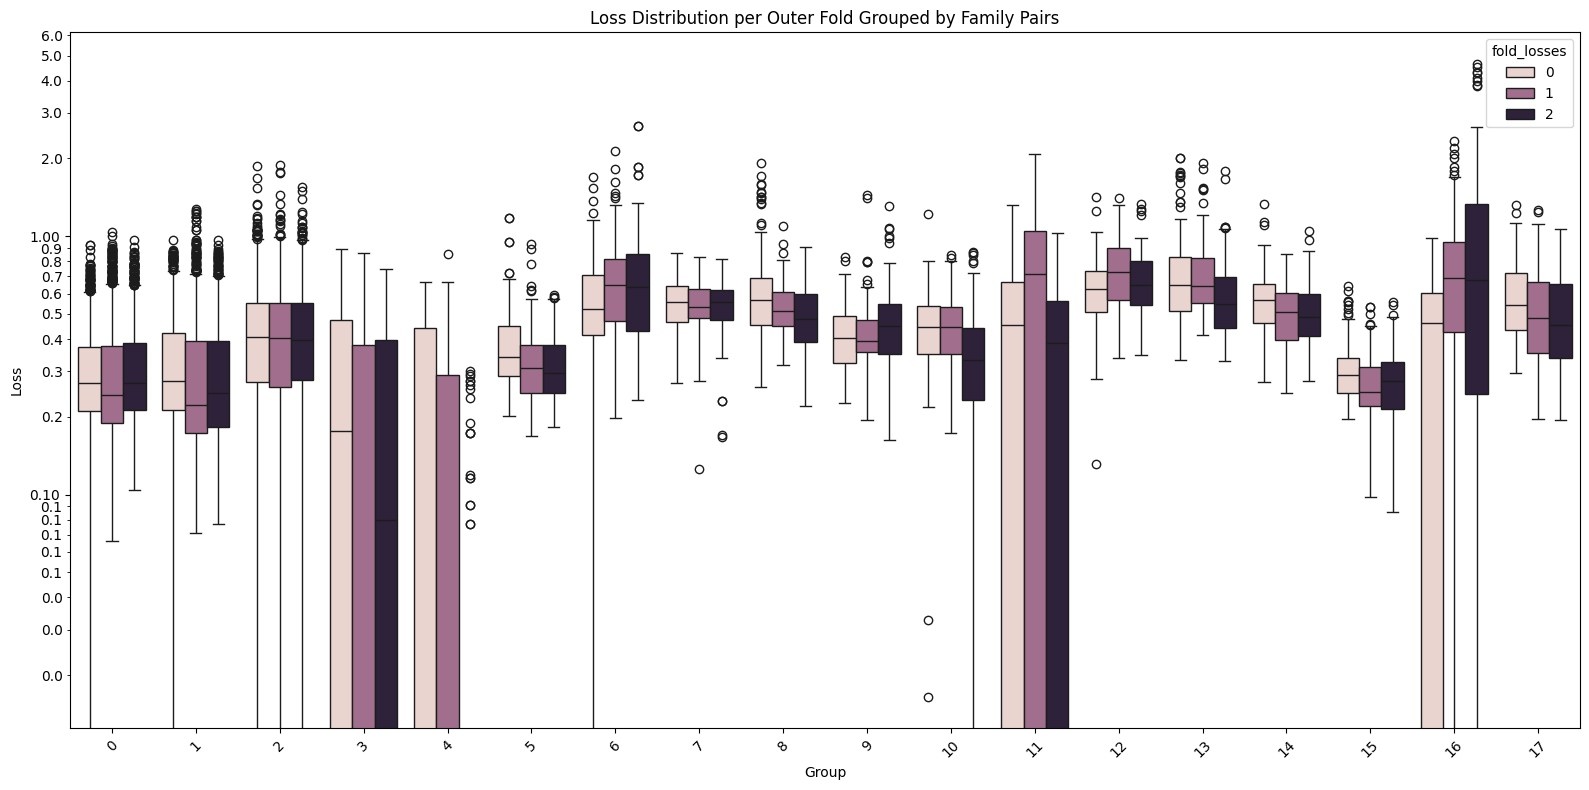

In [72]:
plot_title = "Loss Distribution per Outer Fold Grouped by Family Pairs"
make_plot(sales_predictor.tune_loss_storage, "fold_losses", plot_title)

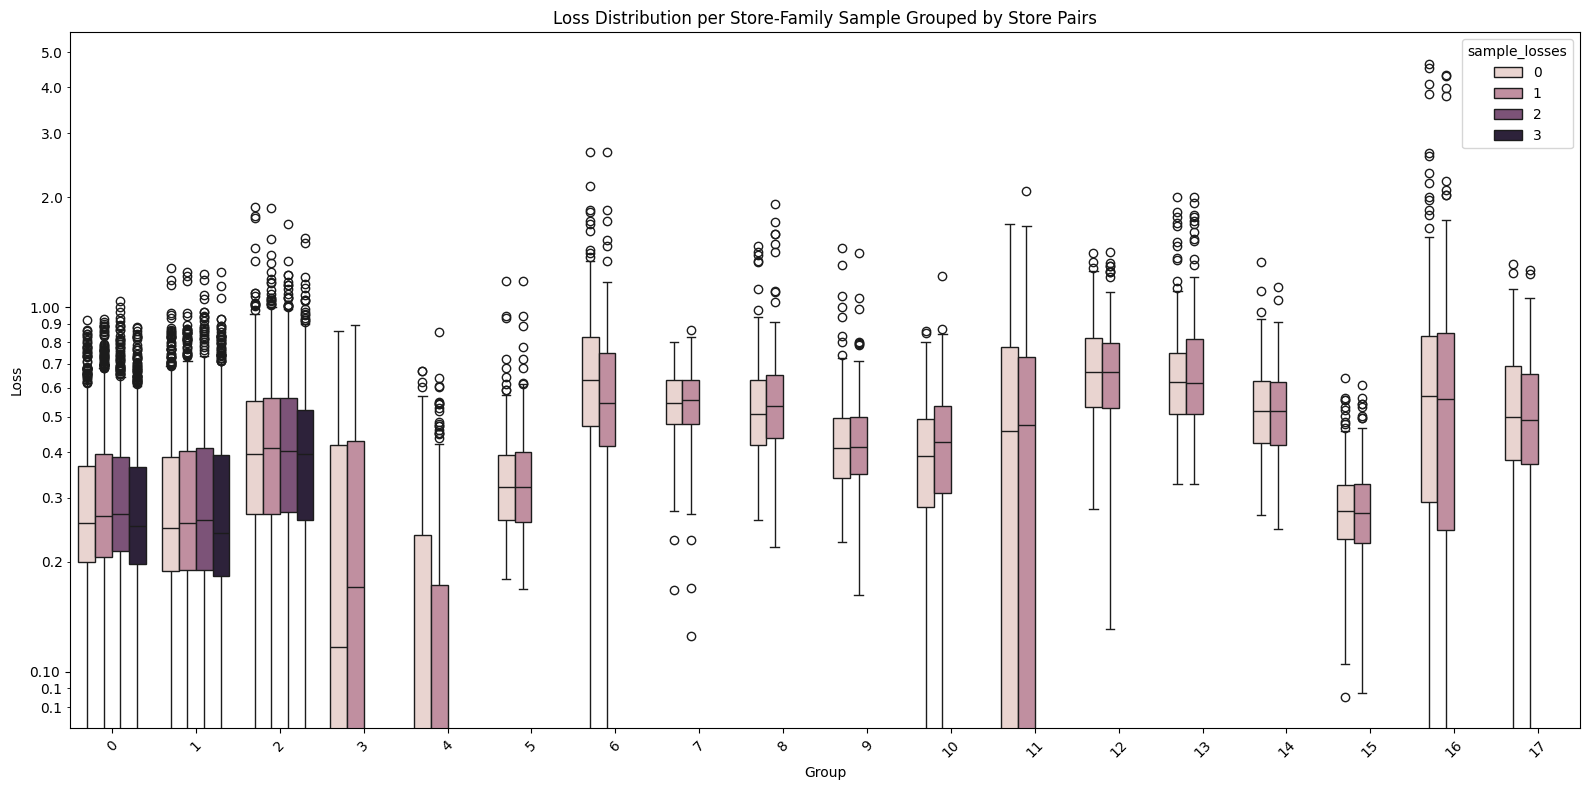

In [71]:
plot_title = "Loss Distribution per Store-Family Sample Grouped by Store Pairs"
make_plot(sales_predictor.tune_loss_storage, "sample_losses", plot_title)

## Make Submission

In [15]:
sales_predictor.fit(train_df, initial)

100%|██████████| 1782/1782 [02:36<00:00, 11.40it/s]


In [16]:
submission = load_submission()

In [17]:
tuned_submission = sales_predictor.predict(test_df, submission)

100%|██████████| 1782/1782 [00:09<00:00, 196.39it/s]


In [18]:
tuned_submission[~tuned_submission["sales"].isna()]

,sales
id,
3000888,5.173913
3000889,0.000000
3000890,3.840000
3000891,2281.960000
3000892,0.062500
...,...
3029395,397.408238
3029396,96.785522
3029397,1672.013056


In [19]:
import os

submission_file_path = os.path.join(SUBMISSIONS_PATH, "test_refactored.csv")
tuned_submission.to_csv(submission_file_path)